In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from tensorneat.algorithm.neat import NEAT
from tensorneat.algorithm.hyperneat import HyperNEAT, FullSubstrate
from tensorneat.genome import DefaultGenome
from tensorneat.genome.operations import DefaultMutation
from tensorneat.genome.gene import DefaultConn
from tensorneat.problem import BraxEnv
from tensorneat.common import ACT

import wandb
from custom_pipeline import CustomPipeline
from manual_dim_mapping import SubstrateGenerator
import os

ModuleNotFoundError: No module named 'dim_tuning'

In [ ]:

# change log
# manual mapping for ant --- worse than without
# lower survival threshold, higher mutation rates --- no significant improvement
# mutation rates changed back to lower values, additional hidden layers (2 to 4) with only one_double_hot (two_hot before), higher pop size --- faster convergence, end result same
# lower survival threshold, more gens, species fitness mean (before max) --- hardly any improvement in max fitness for 20 gen, then similiar

# next change: hidden layers number, hidden layers type, higher mutation rates



Tested [Brax environments](https://github.com/google/brax/tree/main/brax/envs):
* ant
* halfcheetah
* swimmer

In [ ]:
ENV_NAME = "ant"
WANDB_NAME_SUFFIX = "man"

ENV_BACKEND = "generalized"  # ['generalized', 'positional', 'spring']
MAX_STEP = 5000
FITNESS_TARGET = 5000.0

GENERATION_LIMIT = 150
POP_SIZE = 600
SPECIES_SIZE = 20

In [ ]:
HIDDEN_LAYER_TYPE = "one_double_hot"        # ["shift" / "one_hot" / "two_hot" / "one_double_hot"], defaults to one_hot
HIDDEN_DEPTH = 4                            # >=1

REPEAT_TIMES = 5 
WEIGHT_TRESHOLD = 0.1
WEIGHT_LOWER_BOUND=-1.0
WEIGHT_UPPER_BOUND=1.0


In [ ]:
OUTPUT_DIR = f"output/{ENV_NAME}"
if not os.path.exists(f"output"):
    os.mkdir("output")
if not os.path.exists(f"{OUTPUT_DIR}"):
    os.mkdir(f"{OUTPUT_DIR}")

In [ ]:
env_problem = BraxEnv(
    env_name=ENV_NAME,
    backend=ENV_BACKEND,
    max_step=MAX_STEP,
    repeat_times=REPEAT_TIMES,
    obs_normalization=False,
    sample_episodes=16,
    )
obs_size = env_problem.input_shape[0]
act_size = env_problem.output_shape[0]

/home/andi/anaconda3/envs/jax/lib/python3.10/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


In [ ]:
substrate_gen = SubstrateGenerator(
    env_name=ENV_NAME,
    obs_size=obs_size,
    act_size=act_size,
    hidden_layer_type=HIDDEN_LAYER_TYPE,
    hidden_depth=HIDDEN_DEPTH,
)

input_coors, coord_size = substrate_gen.get_input_coors()
hidden_coors = substrate_gen.get_hidden_coors(input_coors, coord_size)
output_coors = substrate_gen.get_output_coors(coord_size)

print(f"Final coord_size: {coord_size}")
print(f"Number of input neurons: {len(input_coors)}")
print("input_coors: ", input_coors)
print(f"Number of hidden neurons: {len(hidden_coors)}")
print(f"Number of output neurons: {len(output_coors)}")

Final coord_size: 12
Number of input neurons: 28
input_coors:  [(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0, 1.0, 1.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0, 1.0, -1.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, -1.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0, -1.0, 1.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, -1.0, 1.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, -1.0, -1.0, 0.0, 0.0), (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [ ]:
# 4. Create the substrate
active_substrate = FullSubstrate(
    input_coors=input_coors,
    hidden_coors=hidden_coors,
    output_coors=output_coors,
)

In [ ]:
print("query_coors shape:", active_substrate.query_coors.shape)  # (num_queries, query_dim)
query_dim = int(active_substrate.query_coors.shape[1])
print(f"That means {int(query_dim/2)} dimensions with 2 query nodes each.")


query_coors shape: (9280, 24)
That means 12 dimensions with 2 query nodes each.


In [ ]:
conn_gene = DefaultConn(
    weight_mutate_power=0.25,
    weight_mutate_rate=0.3,
    weight_lower_bound=WEIGHT_LOWER_BOUND,
    weight_upper_bound=WEIGHT_UPPER_BOUND,
)

genome=DefaultGenome(
    num_inputs=query_dim,
    num_outputs=1,
    output_transform=ACT.tanh,
    max_nodes=256,
    max_conns=1024,
    init_hidden_layers=[int(query_dim/4)],
    mutation=DefaultMutation(
        node_add=0.4,
        conn_add=0.5, 
        node_delete=0.15,
        conn_delete=0.2,
    ),
    conn_gene=conn_gene,
)

neat_algorithm = NEAT(
    pop_size=POP_SIZE,
    species_size=SPECIES_SIZE,
    survival_threshold=0.10,
    compatibility_threshold=1.0,
    species_fitness_func=jnp.mean, # alternative jnp.mean / jnp.max,
    genome_elitism=5,
    species_elitism=3,
    genome=genome,
)

evol_algorithm = HyperNEAT(
    substrate=active_substrate,
    neat=neat_algorithm,
    activation=ACT.tanh,
    activate_time=25, # How many internal activation steps per simulation step (recurrence)
    output_transform=ACT.tanh,
    weight_threshold=WEIGHT_TRESHOLD,
)

In [ ]:
print("Total observation shape:", env_problem.input_shape)
print("Total action shape:", env_problem.output_shape)

print("Substrate input dimension:", active_substrate.query_coors.shape[1])
print("Algorithm input dimension:", evol_algorithm.num_inputs)

Total observation shape: (27,)
Total action shape: (8,)
Substrate input dimension: 24
Algorithm input dimension: 27


In [ ]:
wanbd_name = f"{ENV_NAME}_{WANDB_NAME_SUFFIX}" if WANDB_NAME_SUFFIX != "" else ENV_NAME
WANDB_TAGS = [HIDDEN_LAYER_TYPE, ENV_NAME]

wandb.init(name=wanbd_name, project="connection_cost", tags=WANDB_TAGS)

wandb: Currently logged in as: wirkelzirkel (wirkelzirkel-iu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
pipeline = CustomPipeline(
    algorithm=evol_algorithm,
    problem=env_problem,
    seed=42,
    generation_limit=GENERATION_LIMIT,
    fitness_target=FITNESS_TARGET,
    is_save=False,
    save_dir=OUTPUT_DIR,
)

save to output/ant


In [ ]:
init_state = pipeline.setup()
state = pipeline.auto_run(
    state=init_state
)

print(f"\nTraining finished. Best fitness achieved: {pipeline.best_fitness}")

wandb.finish()

initializing
initializing finished
start compile


2025-09-02 15:34:39.058424: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3023] Can't reduce memory use below 10.99GiB (11797581604 bytes) by rematerialization; only reduced to 15.96GiB (17138481608 bytes), down from 16.40GiB (17610340832 bytes) originally


compile finished, cost time: 24.938087s
Generation: 1, Cost time: 12954.31ms
 	fitness: valid cnt: 600, max: -13.3272, min: -1941.0839, mean: -509.0663, std: 451.1577

	node counts: max: 32, min: 30, mean: 31.25
 	conn counts: max: 152, min: 124, mean: 146.86
 	species: 2, [591, 9]

Generation: 2, Cost time: 12649.27ms
 	fitness: valid cnt: 600, max: -13.7089, min: -2316.0898, mean: -427.2791, std: 431.3452

	node counts: max: 32, min: 30, mean: 31.25
 	conn counts: max: 152, min: 124, mean: 146.98
 	species: 3, [597, 2, 1]

Generation: 3, Cost time: 12619.84ms
 	fitness: valid cnt: 600, max: -15.4284, min: -2960.0850, mean: -887.0435, std: 450.0616

	node counts: max: 33, min: 30, mean: 31.24
 	conn counts: max: 152, min: 124, mean: 146.34
 	species: 2, [597, 3]

Generation: 4, Cost time: 12689.00ms
 	fitness: valid cnt: 600, max: -13.9693, min: -3016.5007, mean: -162.1967, std: 305.1859

	node counts: max: 33, min: 30, mean: 31.23
 	conn counts: max: 153, min: 100, mean: 123.90
 	spe

fitness_max,▁▁▁▁▁▁▁▁▁▁▇▅▅▅▇██▇▆██▇▆███▇▇▇▇▇█████████
fitness_mean,▆▆▃▁▆▁▆▇▆▆█▆▆▅▆▇▆▆▇▃▃▆▆▆▆▄▆▄▇▇▇▇▇▇█▇████
fitness_min,▁▂▁▃▄▄▄▅▅▅▅▄▅▆▆█▄▄▆▅█▅▆▅▅█▅▄▄▄▅▄▅▄▅▄▅▆▄▅
fitness_std,▆▄▂▅▇▆▂▃▂▃▁▄▃▃▇▁▄▇▅▆▃▄▃▂▅▄▇█▄▇██▇▆▅▇██▇█
generation,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
fitness_max,1078.07727
fitness_mean,-45.87035
fitness_min,-1754.14294
fitness_std,479.25888
generation,150


In [ ]:
state_for_show = state[0] if isinstance(state, tuple) else state

# Transform the best genome into network parameters
best_genome = pipeline.best_genome

# Use the built-in show method to visualize and save video
pipeline.show(
    state=state_for_show,
    best=best_genome,
    output_type="mp4",
    save_path=f"{OUTPUT_DIR}/agent.mp4",
)


2025-09-02 16:08:19.682608: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-09-02 16:08:19.682622: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-09-02 16:08:19.682627: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-09-02 16:08:19.682631: W external/xla/xla/service/gpu/au

Total reward:  1167.4465


/home/andi/anaconda3/envs/jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


mp4 saved to:  output/ant/agent.mp4


In [ ]:
# visualize cppn
cppn_genome = pipeline.algorithm.neat.genome
cppn_network = cppn_genome.network_dict(state, *best_genome)
cppn_genome.visualize(cppn_network, save_path=f"{OUTPUT_DIR}/cppn_network.svg")

Manually reconstructing the phenotype. A visual layout will be generated.
Substrate has 9280 potential connections.
Visualizing 1628 connections. Excluded loops. Weight threshold: 0.1


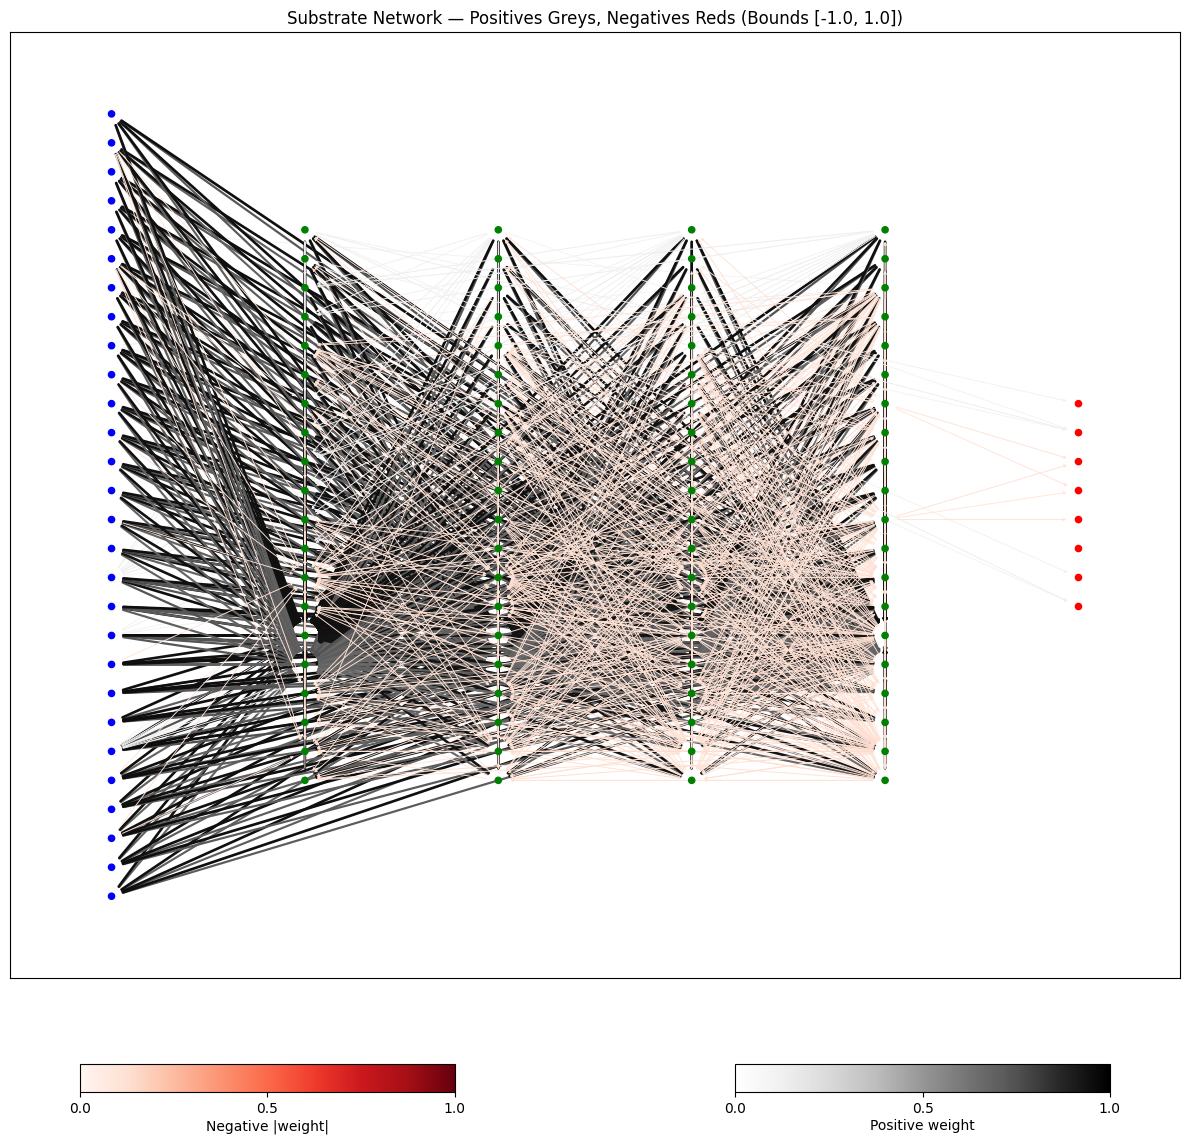

Visualization saved to: output/ant/ANN.svg


In [ ]:
import networkx as nx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

print("Manually reconstructing the phenotype. A visual layout will be generated.")

# 1) Weights from CPPN (your existing logic)
neat_algorithm = pipeline.algorithm.neat
cppn_params = neat_algorithm.transform(state, best_genome)
query_coors = active_substrate.query_coors
cppn_forward_func = neat_algorithm.forward

all_substrate_weights = jax.vmap(
    cppn_forward_func, in_axes=(None, None, 0)
)(state, cppn_params, query_coors)

all_substrate_connections = np.array(active_substrate.conns)
all_substrate_weights_np = np.array(all_substrate_weights).squeeze()

# 2) Select edges: no percentile pruning; keep internal threshold (toggleable)
internal_weight_threshold = pipeline.algorithm.weight_threshold
active_mask = np.abs(all_substrate_weights_np) > internal_weight_threshold
active_conns = all_substrate_connections[active_mask]
active_weights = all_substrate_weights_np[active_mask]

# If you want literally every potential connection regardless of threshold:
# active_conns = all_substrate_connections
# active_weights = all_substrate_weights_np

print(f"Substrate has {len(all_substrate_connections)} potential connections.")

# Build graph, assign layers, generate layout
G_to_draw = nx.DiGraph()
all_node_keys = [int(n[0]) for n in active_substrate.nodes]


# Which coordinate dimension encodes "layer"? In your code it's the last one.
LAYER_AXIS = -1  # last coordinate

def compute_hidden_layer_groups(hidden_coors, layer_axis=LAYER_AXIS):
    """
    Returns:
    order_vals: sorted unique layer values (e.g., 3, 6, 9, ...)
    idx_groups: list of lists; each inner list has indices of hidden nodes that belong to that layer
    widths:     number of hidden nodes per layer (len of each group)
    """
    hc = np.asarray(hidden_coors)
    if hc.ndim != 2:
        raise ValueError(f"hidden_coors must be 2D (num_hidden, coord_dims); got shape {hc.shape}")

    layer_vals = hc[:, layer_axis]
    order_vals = np.unique(layer_vals)
    idx_groups = [np.where(layer_vals == v)[0].tolist() for v in order_vals]
    widths = [len(g) for g in idx_groups]
    return order_vals.tolist(), idx_groups, widths

# Example usage:
order_vals, hidden_idx_groups, hidden_widths = compute_hidden_layer_groups(hidden_coors, layer_axis=LAYER_AXIS)
# All node keys in substrate order (N,1) -> flatten to ints
all_node_keys = [int(n[0]) for n in active_substrate.nodes]

num_inputs  = len(input_coors)
num_outputs = len(output_coors)
num_hiddens = len(hidden_coors)

# Correct slicing for FullSubstrate:
input_keys  = all_node_keys[:num_inputs]
output_keys = all_node_keys[num_inputs : num_inputs + num_outputs]
hidden_keys = all_node_keys[num_inputs + num_outputs : num_inputs + num_outputs + num_hiddens]

# Add nodes to the graph with subsets (partitions) for visualization
G_to_draw = nx.DiGraph()

# Inputs at layer 0
for k in input_keys:
    G_to_draw.add_node(k, subset=0)

# Hidden layers (1..HIDDEN_DEPTH) — we map the *contiguous* hidden range to layers
start_hidden = num_inputs + num_outputs

# If each hidden layer has the same width (classic case):
# hidden_width_full = len(input_coors)  # or len(hidden_coors)//HIDDEN_DEPTH
# But we will use the robust per-layer widths we computed above:
cum = 0
for j, w in enumerate(hidden_widths):
    layer_id = j + 1
    start = start_hidden + cum
    end   = start + w
    for i in range(start, min(end, len(all_node_keys))):
        G_to_draw.add_node(all_node_keys[i], subset=layer_id)
    cum += w

# Outputs at the final layer (after all hidden layers)
output_layer_id = HIDDEN_DEPTH + 1
for k in output_keys:
    G_to_draw.add_node(k, subset=output_layer_id)


# Layout from the detailed layer assignment
pos = nx.multipartite_layout(G_to_draw, subset_key='subset')

# 4) Fixed-bounds grayscale mapping & robust edge extraction

# Helper: coerce bounds to floats (in case 0,0 was typed instead of 0.0)
def _to_float_bound(x, name):
    if isinstance(x, (tuple, list, np.ndarray)):
        if len(x) == 0:
            raise ValueError(f"{name} is empty; set a valid float (e.g., 0.0).")
        x = x[0]
    try:
        return float(x)
    except Exception as e:
        raise ValueError(
            f"Could not convert {name}={x!r} to float. "
            f"Use a scalar like 0.0 or 1.0. Original error: {e}"
        )

LOWER = _to_float_bound(WEIGHT_LOWER_BOUND, "WEIGHT_LOWER_BOUND")
UPPER = _to_float_bound(WEIGHT_UPPER_BOUND, "WEIGHT_UPPER_BOUND")

# Your active_conns rows look like [src, dst, extra]; take first two columns
ac = np.asarray(active_conns)
if ac.ndim != 2 or ac.shape[1] < 2:
    raise ValueError(f"Expected active_conns to have at least 2 columns; got shape {ac.shape}")

all_edges = [(int(row[0]), int(row[1])) for row in ac]
all_weights = np.asarray(active_weights)

# NEW: Filter out self-loops
# Create lists to hold the edges and weights that are NOT self-loops
edges_to_add = []
active_weights_filtered = []
for edge, weight in zip(all_edges, all_weights):
    if edge[0] != edge[1]:  # This condition checks if the edge is NOT a self-loop
        edges_to_add.append(edge)
        active_weights_filtered.append(weight)

# Convert back to a NumPy array for consistency
active_weights = np.array(active_weights_filtered)

print(f"Visualizing {len(active_weights)} connections. Excluded loops. Weight threshold: {internal_weight_threshold}")

# Add edges to graph
G_to_draw.add_edges_from(edges_to_add)

# Magnitudes for color mapping (must align 1:1 with edges_to_add)
abs_w = np.abs(active_weights)
if len(abs_w) != len(edges_to_add):
    raise ValueError(
        f"Edge/weight mismatch: {len(edges_to_add)} edges vs {len(abs_w)} weights. "
        "Ensure any filtering is applied identically to connections and weights."
    )

# Edge-width scaling (optional) using fixed bounds in [0,1]
if abs_w.size > 0:
    norm_for_widths = np.clip((abs_w - LOWER) / (UPPER - LOWER), 0.0, 1.0)
else:
    norm_for_widths = np.array([], dtype=float)

# Node colors: inputs=blue, outputs=red, hidden=green
node_colors = []
for node_key in G_to_draw.nodes():
    if node_key in input_keys:
        color = 'blue'
    elif node_key in output_keys:
        color = 'red'
    else:
        color = 'green'
    node_colors.append(color)

# 5) Draw with separate colormaps for positive (Greys) and negative (Reds)

fig, ax = plt.subplots(figsize=(12, 12))

weights = np.asarray(active_weights)
idx_all = np.arange(len(edges_to_add))

pos_idx = idx_all[weights > 0]
neg_idx = idx_all[weights < 0]
zero_idx = idx_all[weights == 0]  # optional

edges_pos = [edges_to_add[i] for i in pos_idx]
edges_neg = [edges_to_add[i] for i in neg_idx]
w_pos = weights[pos_idx]                # > 0
w_neg_mag = -weights[neg_idx]           # positive magnitudes for negative edges

# Edge widths scaled per side using fixed bounds
eps = np.finfo(float).eps  # protect against division by zero

widths_pos = 0.5 + 1.5 * np.clip(w_pos / max(UPPER, eps), 0.0, 1.0) if len(w_pos) else []
widths_neg = 0.5 + 1.5 * np.clip(w_neg_mag / max(-LOWER, eps), 0.0, 1.0) if len(w_neg_mag) else []

# Draw nodes once
nx.draw_networkx_nodes(
    G_to_draw,
    pos=pos,
    node_color=node_colors,
    node_size=20,
    ax=ax
)

# Draw POSITIVE edges: Greys (white → black), mapped over [0, UPPER]
if len(edges_pos):
    nx.draw_networkx_edges(
        G_to_draw,
        pos=pos,
        edgelist=edges_pos,
        edge_color=w_pos,             # raw positive weights
        edge_cmap=plt.cm.Greys,
        edge_vmin=0.0,
        edge_vmax=float(UPPER),
        width=widths_pos,
        arrows=True,
        arrowstyle='-|>',
        arrowsize=4,
        ax=ax
    )

# Draw NEGATIVE edges: Reds (white → red), mapped over [0, |LOWER|] using magnitudes
if len(edges_neg):
    nx.draw_networkx_edges(
        G_to_draw,
        pos=pos,
        edgelist=edges_neg,
        edge_color=w_neg_mag,         # magnitudes of negative weights
        edge_cmap=plt.cm.Reds,
        edge_vmin=0.0,
        edge_vmax=float(-LOWER),
        width=widths_neg,
        arrows=True,
        arrowstyle='-|>',
        arrowsize=4,
        ax=ax
    )

# Colorbars
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ax.set_title(f"Substrate Network — Positives Greys, Negatives Reds (Bounds [{LOWER}, {UPPER}])")
fig.tight_layout()
fig.subplots_adjust(bottom=0.18) # Manually make space at the bottom for colorbars

# Left: negative (Reds)
if len(w_neg_mag):
    sm_neg = ScalarMappable(cmap=plt.cm.Reds,
                            norm=Normalize(vmin=0.0, vmax=float(-LOWER)))
    sm_neg.set_array([])
    cax_neg = inset_axes(
        ax, width="32%", height="3%", loc="lower left",
        bbox_to_anchor=(0.06, -0.12, 1.0, 1.0),  # left aligned
        bbox_transform=ax.transAxes, borderpad=0
    )
    cbar_neg = fig.colorbar(sm_neg, cax=cax_neg, orientation='horizontal')
    cbar_neg.set_label('Negative |weight|', labelpad=2)
    cbar_neg.ax.xaxis.set_label_position('bottom')
    cbar_neg.ax.xaxis.set_ticks_position('bottom')
    cbar_neg.set_ticks([0, (-LOWER)/2, -LOWER])

# Right: positive (Greys)
if len(w_pos):
    sm_pos = ScalarMappable(cmap=plt.cm.Greys,
                            norm=Normalize(vmin=0.0, vmax=float(UPPER)))
    sm_pos.set_array([])
    cax_pos = inset_axes(
        ax, width="32%", height="3%", loc="lower right",
        bbox_to_anchor=(-0.06, -0.12, 1.0, 1.0),  # right aligned
        bbox_transform=ax.transAxes, borderpad=0
    )
    cbar_pos = fig.colorbar(sm_pos, cax=cax_pos, orientation='horizontal')
    cbar_pos.set_label('Positive weight', labelpad=2)
    cbar_pos.ax.xaxis.set_label_position('bottom')
    cbar_pos.ax.xaxis.set_ticks_position('bottom')
    cbar_pos.set_ticks([0, UPPER/2, UPPER])

out_path = f"{OUTPUT_DIR}/ANN.svg"
fig.savefig(out_path, dpi=800)
plt.show()
plt.close(fig)

print(f"Visualization saved to: {out_path}")

In [ ]:
import pickle
import jax.tree_util as tree_util

# SAVING THE BEST GENOME

# The best_genome is a JAX PyTree living on the GPU/TPU.
# For safe saving, we first pull it to the CPU and convert it to NumPy arrays.
best_genome_numpy = tree_util.tree_map(jax.device_get, best_genome)

# Define the filename
save_filename = f"{OUTPUT_DIR}/best_genome.pkl"

# Use pickle to serialize and save the NumPy version of the genome
with open(save_filename, "wb") as f:
    pickle.dump(best_genome_numpy, f)

print(f"Best genome saved successfully to: {save_filename}")

Best genome saved successfully to: output/ant/best_genome.pkl
